In [1]:
from os import listdir
from os.path import isfile
import numpy as np
import json
import collections
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

Preprocess OpenPose data.

In [2]:
punch_path=r'D:\data\proj8\punchout'
notpunch_path=r'D:\data\proj8\notpunchout'
punch_fname=[f for f in listdir(punch_path) if isfile(os.path.join(punch_path, f))]
notpunch_fname=[f for f in listdir(notpunch_path) if isfile(os.path.join(notpunch_path, f))]

In [113]:
temporal_dim=30

In [78]:
def process_points_to_np(klist,convert_to_local=True):
    new_list=[]
    for i in range(len(klist)):
        if i%3==0: #x
            if convert_to_local:
                if klist[i]==0:
                    new_list.append(klist[i])
                else:
                    new_list.append(klist[i]-klist[0])
            else:
                new_list.append(klist[i])
        elif i%3 ==1:
            if convert_to_local:
                if klist[i]==0:
                    new_list.append(klist[i])
                else:
                    new_list.append(klist[i]-klist[1])
            else:
                new_list.append(klist[i])
        else:
            continue
    return np.array(new_list)

In [79]:
def process_one_file(fpath,json_dir,temporal_dimension=10):
    fname=os.path.basename(fpath)
    fname=fname[:fname.rfind('.')]
    print(fname,json_dir)
    json_fname = [f for f in listdir(json_dir) if isfile(os.path.join(json_dir, f)) and f.startswith(fname)]
    #print(json_fname)
    if len(json_fname)==0:
        print('Warning: No json file found for '+fpath)
        return None
    d={}
    for o in json_fname:
        bar_pos=o.rfind('_')
        d[o]=int(o[bar_pos-12:bar_pos])
    ordered_json_fname=[k for k, v in sorted(d.items(), key=lambda item: item[1])]
    keypoints=[]
    last_skeleton=None
    for j in ordered_json_fname:
        jpath=os.path.join(json_dir, j)
        with open(jpath) as f:
            data = json.load(f)
        if len(data['people'])==0:
            keypoints.append(process_points_to_np([-999]*75,convert_to_local=False))
            last_skeleton=process_points_to_np([-999]*75,convert_to_local=False)
        elif len(data['people'])==1:
            kpts=process_points_to_np(data['people'][0]['pose_keypoints_2d'])
            nonzero_count=0
            for i in kpts:
                if i!=0:
                    nonzero_count+=1
            if nonzero_count<2:
                keypoints.append(process_points_to_np([-999]*75))
                last_skeleton=process_points_to_np([-999]*75,convert_to_local=False)
            else:
                keypoints.append(kpts)
                last_skeleton=process_points_to_np(data['people'][0]['pose_keypoints_2d'],convert_to_local=False)
            #keypoints.append(process_points_to_np(data['people'][0]['pose_keypoints_2d']))
            #last_skeleton=process_points_to_np(data['people'][0]['pose_keypoints_2d'],convert_to_local=False)
        else:
            if len(keypoints)==0:
                #If first frame, pick the largest object
                maxi=-1
                maxv=-1
                for k in range(len(data['people'])):
                    pts=process_points_to_np(data['people'][k]['pose_keypoints_2d'])
                    average_square=0
                    nonzero_count=0
                    for epts in pts:
                        if epts!=0:
                            average_square+=(epts*epts)
                            nonzero_count+=1
                    average_square=average_square/nonzero_count
                    if average_square>maxv:
                        maxv=average_square
                        maxi=k
                keypoints.append(process_points_to_np(data['people'][maxi]['pose_keypoints_2d']))
                last_skeleton=process_points_to_np(data['people'][maxi]['pose_keypoints_2d'],convert_to_local=False)
            else:
                minv=np.inf
                mini=0
                for k in range(len(data['people'])):
                    pts=process_points_to_np(data['people'][k]['pose_keypoints_2d'],convert_to_local=False)
                    square_diff=np.square(pts-last_skeleton).sum()
                    if square_diff<minv:
                        minv=square_diff
                        mini=k
                keypoints.append(process_points_to_np(data['people'][mini]['pose_keypoints_2d']))
                last_skeleton=process_points_to_np(data['people'][mini]['pose_keypoints_2d'],convert_to_local=False)

    point_buffer=collections.deque(maxlen=temporal_dimension)
    out_arr=None
    for i in range(temporal_dimension):
        point_buffer.append(keypoints[0])
    for i in range(len(keypoints)):
        point_buffer.append(keypoints[i])
        if out_arr is None:
            out_arr=np.expand_dims(np.stack(point_buffer,axis=0), axis=0)
        else:
            current_arr=np.expand_dims(np.stack(point_buffer,axis=0), axis=0)
            out_arr=np.concatenate([out_arr,current_arr],axis=0)
    return out_arr

In [80]:
test_size_per_class=0
Xpunch=None
for f in punch_fname[:-test_size_per_class]:
    if Xpunch is None:
        Xpunch=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
        if current_arr is not None:
            Xpunch=np.concatenate([Xpunch,current_arr],axis=0)
Xpunch_test=None
for f in punch_fname[-test_size_per_class:]:
    if Xpunch_test is None:
        Xpunch_test=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(punch_path, f),os.path.join(punch_path, 'jsons'),temporal_dim)
        if current_arr is not None:
            Xpunch_test=np.concatenate([Xpunch_test,current_arr],axis=0)

-aOVo-6wAJw D:\data\proj8\punchout\jsons
-oUA4Ki2VWA D:\data\proj8\punchout\jsons
0ts6ui3-TNw D:\data\proj8\punchout\jsons
0xT3I9lJEdA D:\data\proj8\punchout\jsons
0ZaZz8idco8 D:\data\proj8\punchout\jsons
1R33ibKMA0M D:\data\proj8\punchout\jsons
2ovCxGPhG7M D:\data\proj8\punchout\jsons
2TAYZ67B16E D:\data\proj8\punchout\jsons
3FFl_DC2kIE D:\data\proj8\punchout\jsons
3Kyz5dyPmE4 D:\data\proj8\punchout\jsons
3lNdxrh1pKA D:\data\proj8\punchout\jsons
4QyhLYasQj8 D:\data\proj8\punchout\jsons
5DnpeHrTTuw D:\data\proj8\punchout\jsons
5KdLh4nP5XY D:\data\proj8\punchout\jsons
5no6BywyCpg D:\data\proj8\punchout\jsons
6LmrEYup_Vs D:\data\proj8\punchout\jsons
6mXTqq7TlOk D:\data\proj8\punchout\jsons
7Je4QGMVjUE D:\data\proj8\punchout\jsons
7mT1Xd0Imvc D:\data\proj8\punchout\jsons
7TLngTUG9BU D:\data\proj8\punchout\jsons
7tu8gxbCUGE D:\data\proj8\punchout\jsons
7ZMwJAaFUj4 D:\data\proj8\punchout\jsons
9KxlUOg1L38 D:\data\proj8\punchout\jsons
9LmgNeEhTSI D:\data\proj8\punchout\jsons
9qFV0Er_v0c D:\d

In [81]:
test_size_per_class=0
Xnotpunch=None
for f in notpunch_fname[:-test_size_per_class]:
    if Xnotpunch is None:
        Xnotpunch=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
        if current_arr is not None:
            Xnotpunch=np.concatenate([Xnotpunch,current_arr],axis=0)
Xnotpunch_test=None
for f in notpunch_fname[-test_size_per_class:]:
    if Xnotpunch_test is None:
        Xnotpunch_test=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
    else:
        current_arr=process_one_file(os.path.join(notpunch_path, f),os.path.join(notpunch_path, 'jsons'),temporal_dim)
        if current_arr is not None:
            Xnotpunch_test=np.concatenate([Xnotpunch_test,current_arr],axis=0)

a1 D:\data\proj8\notpunchout\jsons
a11 D:\data\proj8\notpunchout\jsons
a110 D:\data\proj8\notpunchout\jsons
a111 D:\data\proj8\notpunchout\jsons
a112 D:\data\proj8\notpunchout\jsons
a113 D:\data\proj8\notpunchout\jsons
a114 D:\data\proj8\notpunchout\jsons
a115 D:\data\proj8\notpunchout\jsons
a116 D:\data\proj8\notpunchout\jsons
a117 D:\data\proj8\notpunchout\jsons
a118 D:\data\proj8\notpunchout\jsons
a119 D:\data\proj8\notpunchout\jsons
a12 D:\data\proj8\notpunchout\jsons
a120 D:\data\proj8\notpunchout\jsons
a122 D:\data\proj8\notpunchout\jsons
a123 D:\data\proj8\notpunchout\jsons
a124 D:\data\proj8\notpunchout\jsons
a125 D:\data\proj8\notpunchout\jsons
a126 D:\data\proj8\notpunchout\jsons
a127 D:\data\proj8\notpunchout\jsons
a128 D:\data\proj8\notpunchout\jsons
a129 D:\data\proj8\notpunchout\jsons
a13 D:\data\proj8\notpunchout\jsons
a130 D:\data\proj8\notpunchout\jsons
a131 D:\data\proj8\notpunchout\jsons
a132 D:\data\proj8\notpunchout\jsons
a133 D:\data\proj8\notpunchout\jsons
a134 D

In [82]:
#Fix naming error..
Xpunch=Xpunch_test
Xnotpunch=Xnotpunch_test

In [83]:
Xpunch.shape

(22637, 60, 50)

In [84]:
Xnotpunch.shape

(77836, 60, 50)

In [85]:
Xrpunch=Xpunch.copy()
Xrnotpunch=Xnotpunch.copy()

In [86]:
base_pos1=4
base_pos2=10
for i in range(6):
    Xrpunch[:, :, base_pos1+i], Xrpunch[:,:, base_pos2+i] = Xrpunch[:,:, base_pos2+i], Xrpunch[:,:, base_pos1+i].copy()

    
base_pos1=18
base_pos2=24
for i in range(6):
    Xrpunch[:, :, base_pos1+i], Xrpunch[:,:, base_pos2+i] = Xrpunch[:,:, base_pos2+i], Xrpunch[:,:, base_pos1+i].copy()
    
base_pos1=30
base_pos2=32
for i in range(2):
    Xrpunch[:, :, base_pos1+i], Xrpunch[:,:, base_pos2+i] = Xrpunch[:,:, base_pos2+i], Xrpunch[:,:, base_pos1+i].copy()
    
base_pos1=34
base_pos2=36
for i in range(2):
    Xrpunch[:, :, base_pos1+i], Xrpunch[:,:, base_pos2+i] = Xrpunch[:,:, base_pos2+i], Xrpunch[:,:, base_pos1+i].copy()
    
base_pos1=38
base_pos2=44
for i in range(6):
    Xrpunch[:, :, base_pos1+i], Xrpunch[:,:, base_pos2+i] = Xrpunch[:,:, base_pos2+i], Xrpunch[:,:, base_pos1+i].copy()

In [87]:
#Empty training: Use for skipping frames with no person in it
Xempty=np.ones((3000,60,50))*-999

In [88]:
Xnotpunch_combined=np.concatenate([Xempty,Xnotpunch],axis=0)
#Xnotpunch_combined=np.concatenate([Xnotpunch_combined,Xrnotpunch],axis=0)
Xpunch=np.concatenate([Xpunch,Xrpunch],axis=0)
Xall=np.concatenate([Xpunch,Xnotpunch_combined],axis=0)
yall=np.array([1]*Xpunch.shape[0]+[0]*Xnotpunch_combined.shape[0])

In [89]:
np.save('p6.npy', Xpunch)
np.save('np6.npy', Xnotpunch_combined)

In [17]:
# from tempfile import TemporaryFile
# xp = TemporaryFile()
# xnp = TemporaryFile()
# np.save(xp, Xpunch)
# np.save(xnp, Xnotpunch_combined)

In [90]:
yall.shape

(126110,)

In [117]:
Xpunch=np.load('p3.npy')
Xnotpunch_combined=np.load('np3.npy')
Xall=np.concatenate([Xpunch,Xnotpunch_combined],axis=0)
yall=np.array([1]*Xpunch.shape[0]+[0]*Xnotpunch_combined.shape[0])

### Train val split

In [118]:
X_train, X_val, y_train, y_val = train_test_split(Xall, yall, test_size=0.10, random_state=42)

In [119]:
X_train.shape

(113499, 30, 50)

In [120]:
X_val.shape

(12611, 30, 50)

## Model Training

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [121]:
input_shape=(temporal_dim, 50)
model = models.Sequential()
model.add(layers.LSTM(64, dropout=0.2,))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss='hinge',
              metrics=['accuracy'])

In [122]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16,
                    validation_data=(X_val, y_val))

Train on 113499 samples, validate on 12611 samples
Epoch 1/10
113499/113499 [==============================] - 65s 574us/sample - loss: 0.1395 - accuracy: 0.9458 - val_loss: 0.1162 - val_accuracy: 0.9579
Epoch 2/10
113499/113499 [==============================] - 70s 616us/sample - loss: 0.0836 - accuracy: 0.9689 - val_loss: 0.0686 - val_accuracy: 0.9735
Epoch 3/10
113499/113499 [==============================] - 67s 592us/sample - loss: 0.0715 - accuracy: 0.9744 - val_loss: 0.0647 - val_accuracy: 0.9792
Epoch 4/10
113499/113499 [==============================] - 71s 622us/sample - loss: 0.0693 - accuracy: 0.9743 - val_loss: 0.0642 - val_accuracy: 0.9757
Epoch 5/10
113499/113499 [==============================] - 54s 477us/sample - loss: 0.0619 - accuracy: 0.9779 - val_loss: 0.0698 - val_accuracy: 0.9764
Epoch 6/10
113499/113499 [==============================] - 51s 448us/sample - loss: 0.0574 - accuracy: 0.9797 - val_loss: 0.0643 - val_accuracy: 0.9768
Epoch 7/10
113499/113499 [=====

In [ ]:
model.summary()

### Save Model

In [135]:
model.save('proj8302') 

INFO:tensorflow:Assets written to: proj8302\assets


## Model Testing

Enter path to test video and jsons below

In [99]:
test_path=r'D:\data\proj8\testout'
test_fname=[f for f in listdir(test_path) if isfile(os.path.join(test_path, f))]

In [100]:
test_fname

['atest1.mp4',
 'atest2.mp4',
 'atest3.mp4',
 'atest4.mp4',
 'atest5.mp4',
 'atest6.mp4',
 'atest7.mp4']

In [101]:
#temporal_dim

In [102]:
tn='atest2.mp4'

In [103]:
tn

'atest2.mp4'

In [104]:
Xtest=process_one_file(os.path.join(test_path, tn),os.path.join(test_path, 'jsons'),temporal_dim)
y_pred=model.predict_classes(Xtest)

atest2 D:\data\proj8\testout\jsons


In [105]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

atest1 D:\data\proj8\testout\jsons
atest2 D:\data\proj8\testout\jsons
atest3 D:\data\proj8\testout\jsons
atest4 D:\data\proj8\testout\jsons
atest5 D:\data\proj8\testout\jsons
atest6 D:\data\proj8\testout\jsons
atest7 D:\data\proj8\testout\jsons


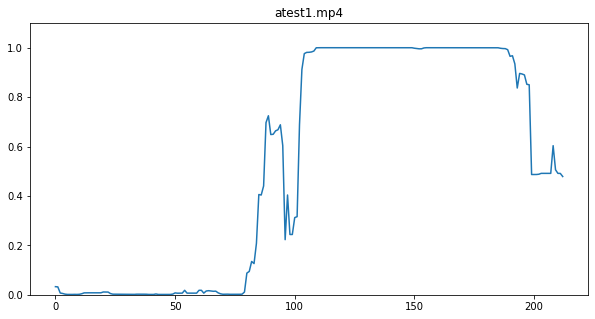

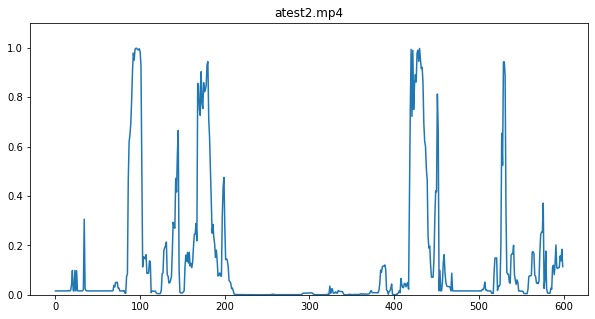

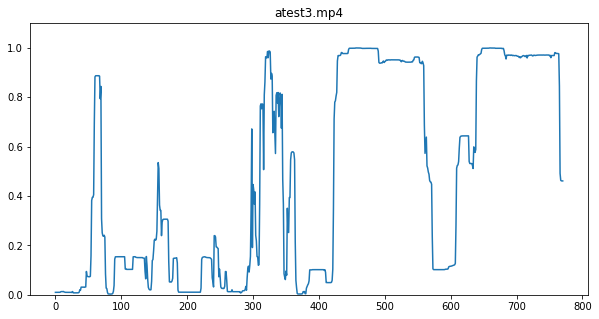

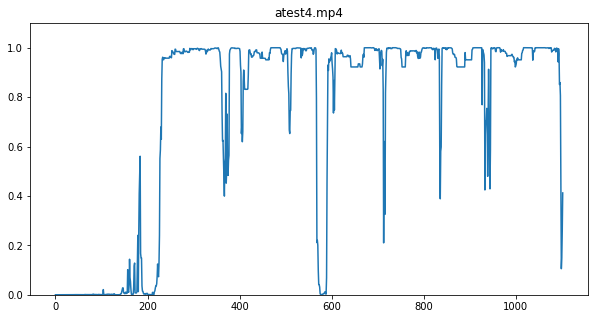

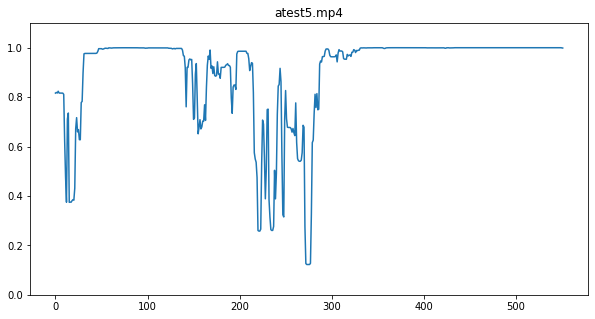

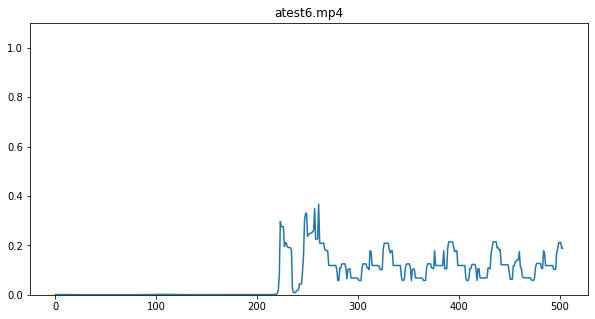

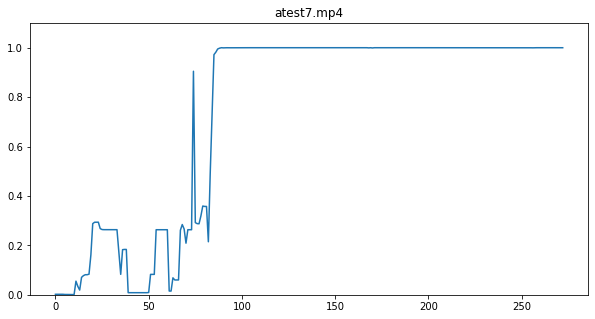

In [107]:
for f in test_fname:
    Xtest=process_one_file(os.path.join(test_path, f),os.path.join(test_path, 'jsons'),temporal_dim)
    y_pred=model.predict(Xtest)
    plt.figure(figsize=(10,5))
    plt.ylim(0.0,1.1)
    plt.plot(y_pred[:,1])
    plt.title(f)
    plt.savefig(os.path.join(test_path,'result/'+f+'.png'))
    #json
    json_out={}
    result_list=[]
    for i in range(y_pred.shape[0]):
        result_list.append([(i/30),y_pred[i,0]])
    json_out["punch"]=result_list
    with open(os.path.join(test_path,'result/'+f+'.json'), 'w+') as outfile:
        json.dump(str(json_out), outfile)

In [144]:
model.save_weights('./mw')

In [57]:
test_path='outpunch'
test_fname=[f for f in listdir(test_path) if isfile(os.path.join(test_path, f))]
is_single_file=len(test_fname)==1

In [58]:
if not os.path.isdir(os.path.join(test_path,'results')):
    os.mkdir(os.path.join(test_path,'results'))

4900_4 outpunch\jsons
5000_4 outpunch\jsons
5100_4 outpunch\jsons
5200_4 outpunch\jsons
5300_1 outpunch\jsons
5300_2 outpunch\jsons
5300_3 outpunch\jsons
5300_4 outpunch\jsons
5400_1 outpunch\jsons
5500_1 outpunch\jsons
5600_1 outpunch\jsons
5700_1 outpunch\jsons


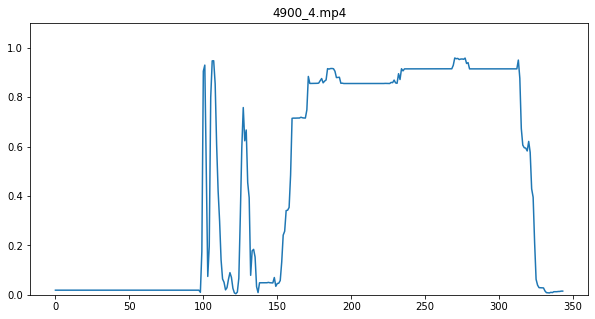

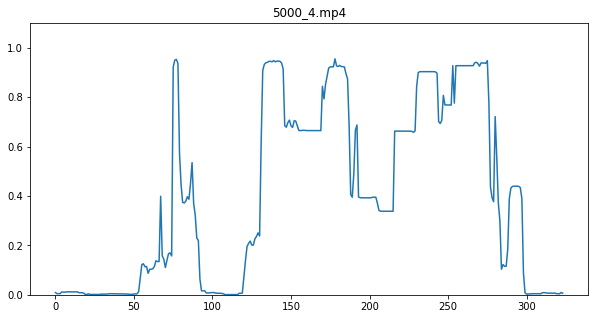

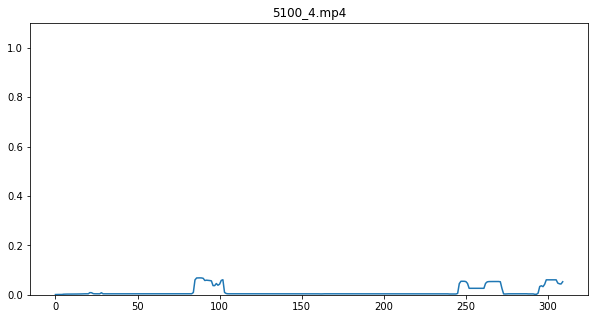

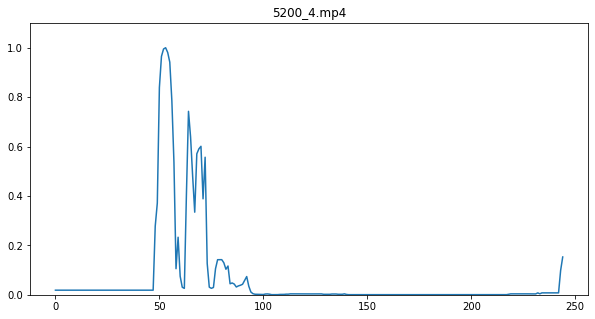

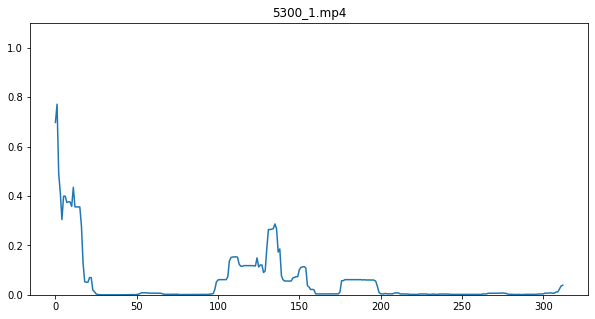

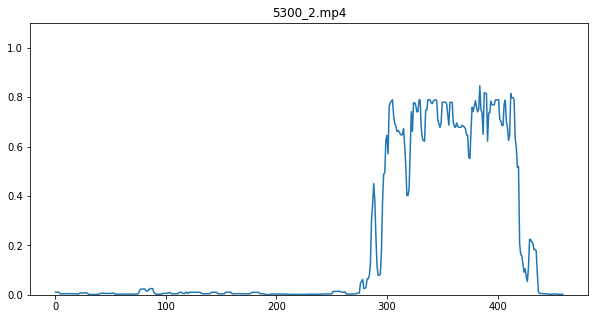

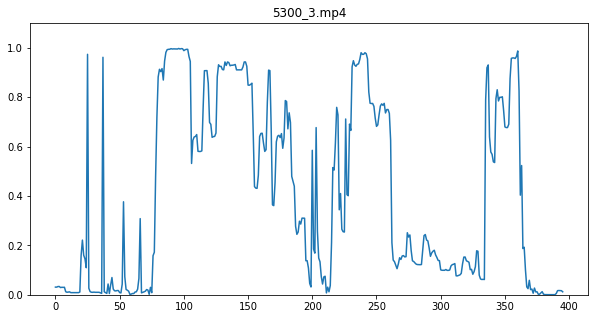

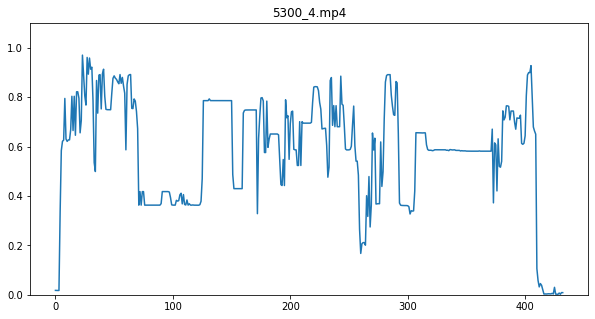

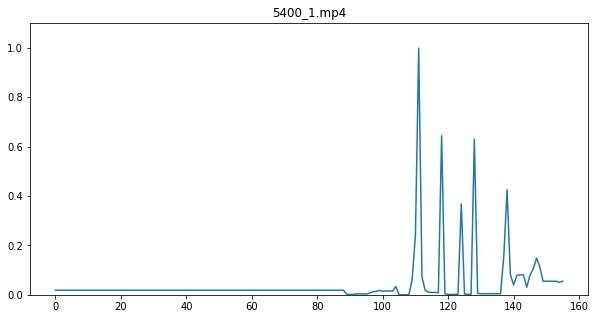

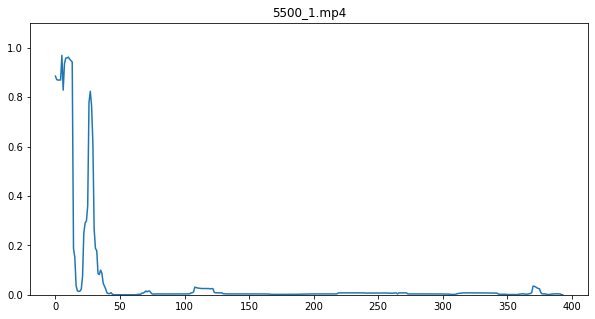

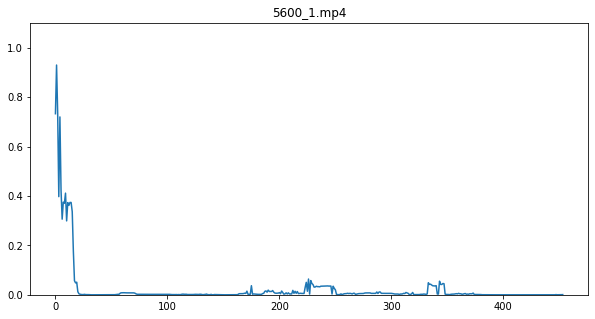

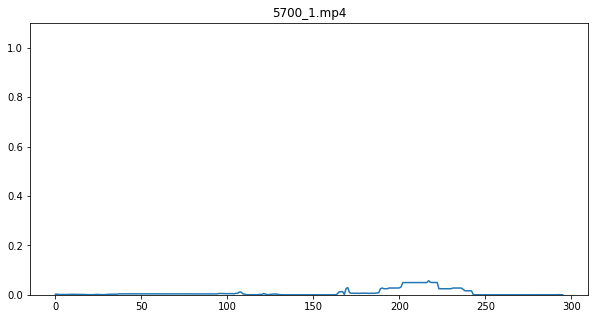

In [136]:
for f in test_fname:
    Xtest=process_one_file(os.path.join(test_path, f),os.path.join(test_path, 'jsons'),temporal_dim)
    if is_single_file:
        pltname='timeLabel.png'
        jsonname='timeLabel.json'
    else:
        pltname=os.path.join(test_path,'results/'+f+'_part8_'+'.png')
        jsonname=os.path.join(test_path,'results/'+f+'_part8_'+'.json')
    y_pred=model.predict(Xtest)
    plt.figure(figsize=(10,5))
    plt.ylim(0.0,1.1)
    plt.plot(y_pred[:,1])
    plt.title(f)
    plt.savefig(pltname)
    #json
    json_out={}
    result_list=[]
    for i in range(y_pred.shape[0]):
        result_list.append([(i/30),y_pred[i,0]])
    json_out["punch"]=result_list
    with open(jsonname, 'w+') as outfile:
        json.dump(str(json_out), outfile)
    if is_single_file:
        Image.open('timeLabel.png').convert("RGB").save('timeLabel.jpg','JPEG')

4900_4 outpunch\jsons
5000_4 outpunch\jsons
5100_4 outpunch\jsons
5200_4 outpunch\jsons
5300_1 outpunch\jsons
5300_2 outpunch\jsons
5300_3 outpunch\jsons
5300_4 outpunch\jsons
5400_1 outpunch\jsons
5500_1 outpunch\jsons
5600_1 outpunch\jsons
5700_1 outpunch\jsons


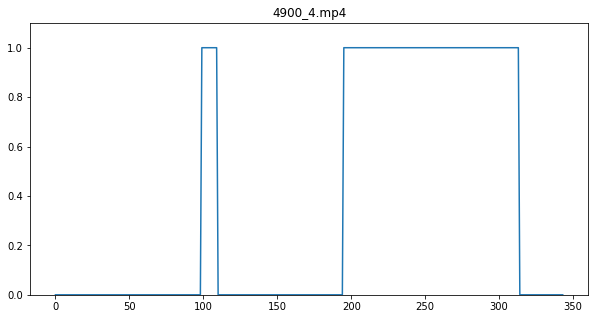

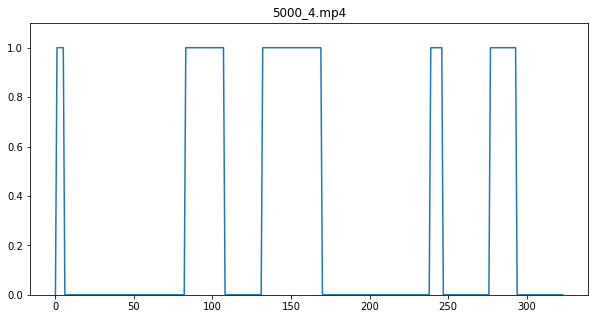

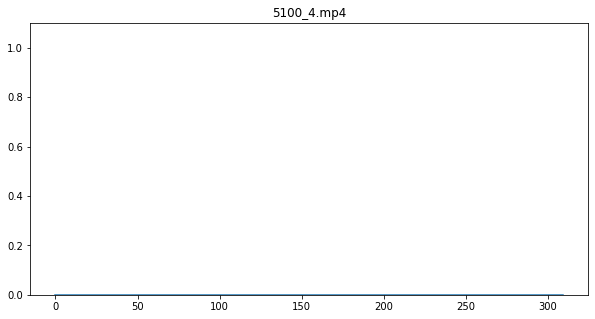

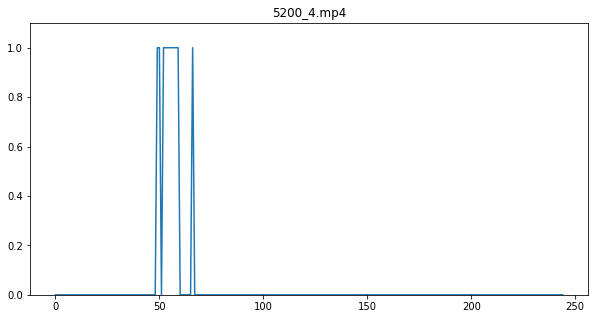

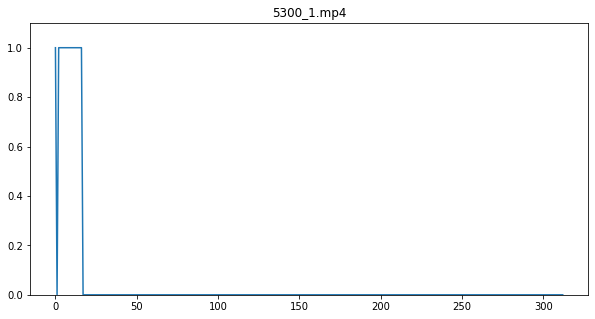

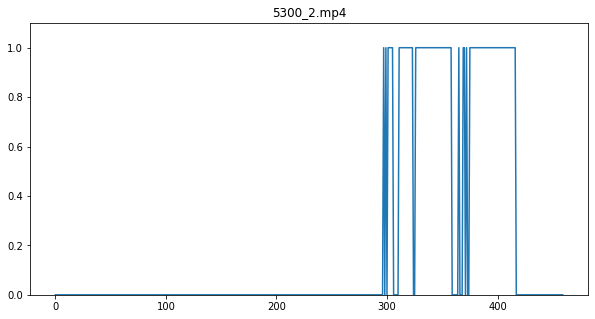

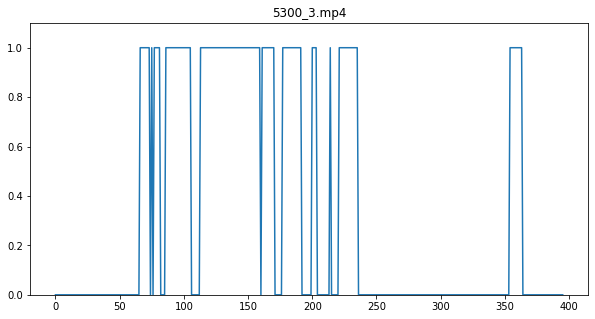

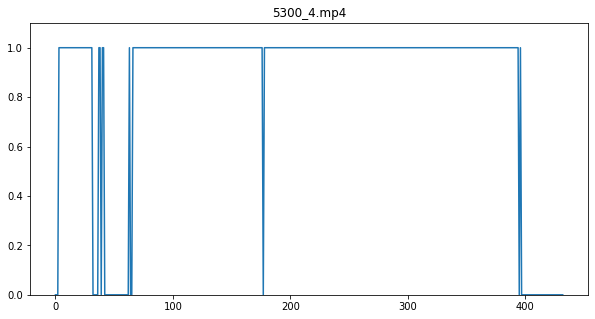

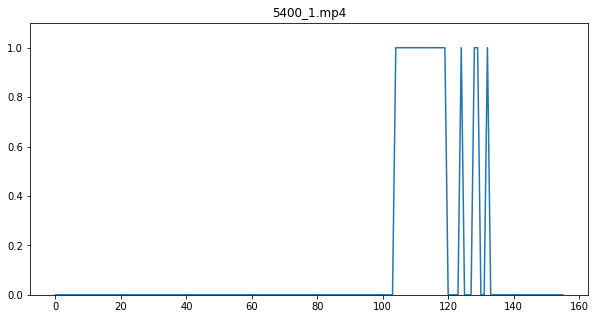

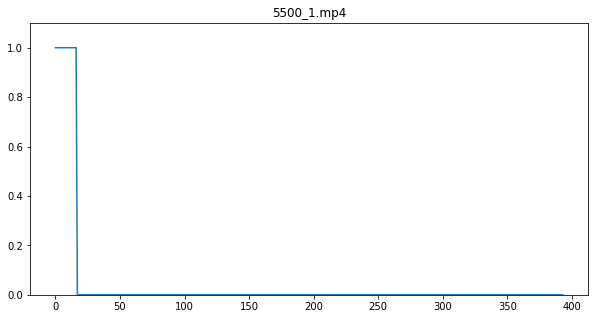

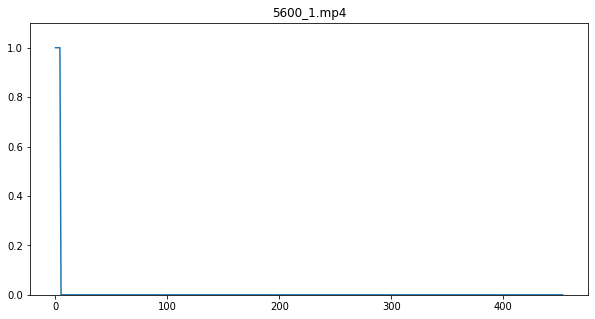

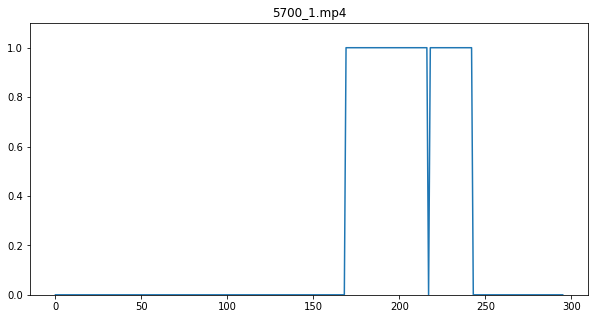

In [76]:
for f in test_fname:
    Xtest=process_one_file(os.path.join(test_path, f),os.path.join(test_path, 'jsons'),temporal_dim)
    if is_single_file:
        pltname='timeLabel.png'
        jsonname='timeLabel.json'
    else:
        pltname=os.path.join(test_path,'results/'+f+'.png')
        jsonname=os.path.join(test_path,'results/'+f+'.json')
    y_pred=model.predict_classes(Xtest)
    plt.figure(figsize=(10,5))
    plt.ylim(0.0,1.1)
    plt.plot(y_pred)
    plt.title(f)
    plt.savefig(pltname)
    #json
    json_out={}
    result_list=[]
    for i in range(y_pred.shape[0]):
        result_list.append([(i/30),y_pred])
    json_out["punch"]=result_list
    with open(jsonname, 'w+') as outfile:
        json.dump(str(json_out), outfile)
    if is_single_file:
        Image.open('timeLabel.png').convert("RGB").save('timeLabel.jpg','JPEG')